# Обучение модели

In [1]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path

MODEL_NAME = 'gama_ASH_1_AS'  # GAMA + Asynchronous Successive Halving Algorithm + 1 + Andrey Sovtsov 
NOTEBOOK_ID = '3'
RANDOM_SEED = 0  # для воспроизводимости результатов
ROOT_PATH = Path('..')  # путь к корню проекта

# Отключаем печать некоторых предупреждений
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import importlib.util
import sys

import dill
import pandas as pd

import uai.data
import uai.models

In [3]:
df = pd.read_csv(ROOT_PATH / 'data/processed/data_for_model_1.csv')
df.head(3)

,id,age,dose,prev_INR(MHO),atrial_fibrillation,mitral_valve,aortal_valve,date_diff,INR(MHO),sample,...,institution_id_22,institution_id_23,institution_id_24,institution_id_25,institution_id_26,institution_id_27,institution_id_28,institution_id_29,institution_id_30,institution_id_31
0,140361892057136,57,7.5,3.11,1,0,0,13.0,3.32,1,...,0,0,0,0,0,0,0,0,0,0
1,140361892057136,57,7.5,3.32,1,0,0,15.0,2.01,2,...,0,0,0,0,0,0,0,0,0,0
2,140361892057264,50,5.0,2.01,0,1,0,26.0,2.75,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Делим исходные данные на тренировочную и тестовую выборки

X_train, X_test, y_train, y_test = uai.data.custom_train_test_split(df, RANDOM_SEED)

In [5]:
# Загружаем еще не обученный пайплайн, существующий пока в виде кода на Питоне

spec = importlib.util.spec_from_file_location(
    MODEL_NAME,
    ROOT_PATH / f'models/{MODEL_NAME}.py'
)
module = importlib.util.module_from_spec(spec)
sys.modules[MODEL_NAME] = module
spec.loader.exec_module(module)
model = module.pipeline
model

Pipeline(steps=[('ord-enc', OrdinalEncoder(cols=[], drop_invariant=True)),
                ('oh-enc', OneHotEncoder(cols=[])),
                ('target_enc', TargetEncoder(cols=[])),
                ('imputation', SimpleImputer(strategy='median')),
                ('1',
                 FeatureAgglomeration(affinity='manhattan', linkage='average')),
                ('0',
                 KNeighborsRegressor(n_neighbors=93, p=1, weights='distance'))])

In [6]:
# Обучение модели 

model.fit(X_train, y_train)

### Прогноз и расчет точности на полном наборе данных
# X_test = df.drop(columns=features2remove, axis=1)
# y_test = df['dose']

# Предсказание
predictions = model.predict(X_test)
rpredictions = [round(x, 3) for x in predictions]  # округление до точности исходных данных

scores = uai.models.calculate_metrics(rpredictions, y_test)
uai.models.print_metrics(scores)

Средняя абсолютная ошибка (MAE):                         0.38
Среднеквадратичная ошибка (MSE):                         0.66
Коэффициент детерминации (R^2):                          0.73
Средняя абсолютная процентная ошибка (MAPE):            13.61%
Доля предсказаний с отклонением не более 0,5 мг:        72.26%


Лучшие значения из экспериментов Андрея Совцова (просто для сравнения):
```
Средняя абсолютная ошибка (MAE):                         0.36
Среднеквадратичная ошибка (MSE):                         0.66
Коэффициент детерминации (R^2):                          0.73
Средняя абсолютная процентная ошибка (MAPE):            13.32%
Доля предсказаний с отклонением не более 0,5 мг:        72.60%
```

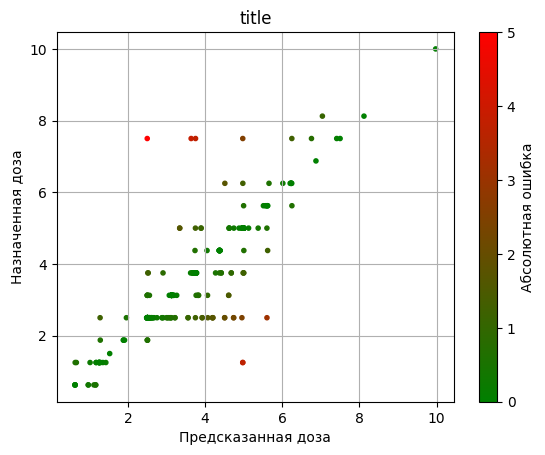

In [7]:
uai.models.plot_predictions(rpredictions, y_test, 'Сравненние на тестовой выборке')

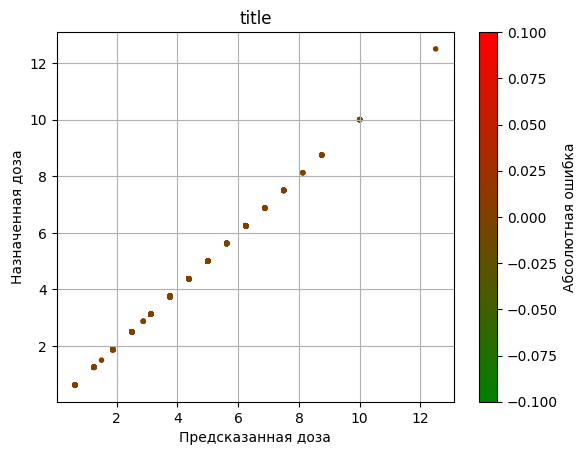

In [8]:
y_pred = model.predict(X_train)
uai.models.plot_predictions(y_pred, y_train, title='Сравнения на обучающей выборке')

In [9]:
# Сохраняем обученную модель в файл

fname = ROOT_PATH / f'models/{MODEL_NAME}.dill'
with open(fname, 'wb') as f:
    dill.dump(model, f, recurse=True)

In [10]:
# Если ничего не напечаталось - то не дошли сюда, и где-то в ноутбуке ошибка
import datetime as dt
print('Ноутбук завершен:', dt.datetime.now())

Ноутбук завершен: 2023-11-07 14:15:22.504410
